#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 14
**CH14B Predicting AirBnB apartment prices: selecting a regression model**

using the airbnb dataset

version 1.0 2022-10-06

In [1]:
import os
import sys
import warnings

import numpy as np
import patsy
import pandas as pd
import statsmodels.formula.api as smf
from mizani.formatters import percent_format
from plotnine import *

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold
import statsmodels.api as smf
import statsmodels.formula.api as smf

warnings.filterwarnings("ignore")


### Part 1

In [2]:
# !!! make sure you have run ch14_airbnb_prepare.ipynb before
data = pd.read_csv("/workspaces/codespaces-jupyter/data/airbnb_hackney_workfile_adj.csv")

Quick look at data

In [3]:
data.describe()

,usd_cleaning_fee,usd_price_day,p_host_response_rate,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,n_guests_included,n_reviews_per_month,n_extra_people,...,f_bathroom,ln_number_of_reviews,f_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating,f_minimum_nights
count,2769.000000,4496.000000,2970.000000,4496.000000,4487.000000,3073.000000,4496.000000,4496.000000,3147.000000,4496.000000,...,4487.000000,4496.000000,4495.000000,3146.000000,3146.000000,3146.000000,3.147000e+03,3.147000e+03,3073.000000,4495.000000
mean,31.439870,80.556940,90.924579,2.864324,1.225986,93.323788,10.141904,1.385454,0.946295,5.991770,...,1.150435,1.414416,0.745050,5.813246,34.920619,214.912424,4.386975e+05,5.008933e+08,4.529253,2.029366
std,25.871418,58.915794,21.642376,1.722148,0.480064,9.133501,22.342473,0.996658,1.143208,11.255617,...,0.379318,1.318117,0.529467,1.061670,11.357470,96.884368,6.959114e+05,1.179754e+09,0.130507,0.838032
min,4.000000,10.000000,0.000000,1.000000,0.000000,20.000000,0.000000,1.000000,0.020000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2.995732,1.000000
25%,15.000000,40.000000,96.000000,2.000000,1.000000,90.000000,0.000000,1.000000,0.210000,0.000000,...,1.000000,0.000000,0.000000,5.269144,27.763878,146.291911,3.763600e+04,7.301384e+06,4.499810,1.000000
50%,25.000000,65.000000,100.000000,2.000000,1.000000,96.000000,2.000000,1.000000,0.520000,0.000000,...,1.000000,1.098612,1.000000,6.006350,36.076248,216.686649,1.640250e+05,6.643012e+07,4.564348,2.000000
75%,40.000000,100.000000,100.000000,4.000000,1.500000,100.000000,10.000000,1.000000,1.190000,10.000000,...,1.000000,2.397895,1.000000,6.512487,42.412491,276.210824,4.529300e+05,3.048232e+08,4.605170,3.000000
max,500.000000,850.000000,100.000000,16.000000,8.000000,100.000000,290.000000,12.000000,9.729999,200.000000,...,2.000000,5.673323,2.000000,7.773594,60.428771,469.748759,5.650129e+06,1.343036e+10,4.605170,3.000000


where do we have missing variables now?

In [4]:
data.isnull().sum().loc[lambda x: x > 0]

usd_cleaning_fee           1727
p_host_response_rate       1526
n_bathrooms                   9
n_review_scores_rating     1423
n_reviews_per_month        1349
n_beds                       12
n_days_since               1349
ln_beds                      12
f_bathroom                    9
f_number_of_reviews           1
ln_days_since              1350
ln_days_since2             1350
ln_days_since3             1350
n_days_since2              1349
n_days_since3              1349
ln_review_scores_rating    1423
f_minimum_nights              1
dtype: int64

What to do with missing values?

   1. drop if no target (already did)

In [5]:
data = data.dropna(subset=["price"])

 2. imput when few, not that important

In [6]:
data["n_bathrooms"] = data["n_bathrooms"].fillna(np.nanmedian(data["n_bathrooms"]))
data["n_beds"] = data["n_beds"].fillna(data["n_accommodates"])
data["f_bathroom"] = data["f_bathroom"].fillna(1)
data["f_minimum_nights"] = data["f_minimum_nights"].fillna(1)
data["f_number_of_reviews"] = data["f_number_of_reviews"].fillna(1)
data["ln_beds"] = data["ln_beds"].fillna(0)


In [7]:
data["n_bathrooms"].describe()


count    4496.000000
mean        1.225534
std         0.479690
min         0.000000
25%         1.000000
50%         1.000000
75%         1.500000
max         8.000000
Name: n_bathrooms, dtype: float64

 3. drop columns when many missing not imortant

In [8]:
data = data.drop(["usd_cleaning_fee", "p_host_response_rate"], axis=1)

 where do we have missing variables now?

In [9]:
data.isnull().sum().loc[lambda x: x > 0]

n_review_scores_rating     1423
n_reviews_per_month        1349
n_days_since               1349
ln_days_since              1350
ln_days_since2             1350
ln_days_since3             1350
n_days_since2              1349
n_days_since3              1349
ln_review_scores_rating    1423
dtype: int64

 4. Replace missing variables re reviews with zero, when no review + add flags

In [10]:
for var in ["flag_days_since", "flag_review_scores_rating", "flag_reviews_per_month"]:
    data[var] = [int(x) for x in data[var.replace("flag", "n")].isna()]

In [11]:
data["n_days_since"] = data["n_days_since"].fillna(np.nanmedian(data["n_days_since"]))
data["n_review_scores_rating"] = data["n_review_scores_rating"].fillna(
    np.nanmedian(data["n_review_scores_rating"])
)
data["n_reviews_per_month"] = data["n_reviews_per_month"].fillna(
    np.nanmedian(data["n_reviews_per_month"])
)


In [12]:
data.flag_days_since.value_counts()

flag_days_since
0    3147
1    1349
Name: count, dtype: int64

Add features -> different functional forms

Create variables, measuring the time since: squared, cubic, logs


In [13]:
data = data.assign(
    ln_days_since=lambda x: np.log(x["n_days_since"] + 1),
    ln_days_since2=lambda x: np.log(x["n_days_since"] + 1) ** 2,
    ln_days_since3=lambda x: np.log(x["n_days_since"] + 1) ** 3,
    n_days_since2=lambda x: x["n_days_since"] ** 2,
    n_days_since3=lambda x: x["n_days_since"] ** 3,
    ln_review_scores_rating=lambda x: np.log(x["n_review_scores_rating"]),
).assign(
    ln_days_since=lambda x: np.where(
        x["ln_days_since"].isnull(), 0, x["ln_days_since"]
    ),
    ln_days_since2=lambda x: np.where(
        x["ln_days_since2"].isnull(), 0, x["ln_days_since2"]
    ),
    ln_days_since3=lambda x: np.where(
        x["ln_days_since3"].isnull(), 0, x["ln_days_since3"]
    ),
)

Look at data

In [14]:
data.describe()

,usd_price_day,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,n_guests_included,n_reviews_per_month,n_extra_people,n_minimum_nights,n_beds,...,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating,f_minimum_nights,flag_days_since,flag_review_scores_rating,flag_reviews_per_month
count,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,...,4496.000000,4496.000000,4496.000000,4.496000e+03,4.496000e+03,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000
mean,80.556940,2.864324,1.225534,94.170819,10.141904,1.385454,0.818387,5.991770,3.127002,1.577847,...,5.874549,35.296294,215.650102,3.562836e+05,3.705350e+08,4.540361,2.029137,0.300044,0.316504,0.300044
std,58.915794,1.722148,0.479690,7.652561,22.342473,0.996658,0.976154,11.255617,6.160668,1.044372,...,0.886647,9.482548,80.906146,5.956503e+05,1.006861e+09,0.109118,0.838079,0.458328,0.465164,0.458328
min,10.000000,1.000000,0.000000,20.000000,0.000000,1.000000,0.020000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2.995732,1.000000,0.000000,0.000000,0.000000
25%,40.000000,2.000000,1.000000,93.000000,0.000000,1.000000,0.330000,0.000000,1.000000,1.000000,...,5.551989,30.824581,171.137760,6.592075e+04,1.692525e+07,4.532599,1.000000,0.000000,0.000000,0.000000
50%,65.000000,2.000000,1.000000,96.000000,2.000000,1.000000,0.520000,0.000000,2.000000,1.000000,...,6.006353,36.076278,216.686868,1.640250e+05,6.643012e+07,4.564348,2.000000,0.000000,0.000000,0.000000
75%,100.000000,4.000000,1.500000,98.000000,10.000000,1.000000,0.860000,10.000000,3.000000,2.000000,...,6.335054,40.132912,254.244177,3.169690e+05,1.784535e+08,4.584967,3.000000,1.000000,1.000000,1.000000
max,850.000000,16.000000,8.000000,100.000000,290.000000,12.000000,9.729999,200.000000,180.000000,16.000000,...,7.774015,60.435310,469.825014,5.650129e+06,1.343036e+10,4.605170,3.000000,1.000000,1.000000,1.000000


 where do we have missing variables now?

In [15]:
data.isnull().sum().loc[lambda x: x > 0]

Series([], dtype: int64)

### Business logic - define our prediction problem

Decision

Size, we need a normal apartment, 1-7persons

In [16]:
data = data.loc[data.n_accommodates < 8]

In [17]:
data.to_csv("airbnb_hackney_work.csv", index=False)

### Look at some descriptive statistics

How is the average price changing in my district by `property_type`, `room_type` and the `bed_type`?

In [18]:
data.groupby(["f_property_type", "f_room_type"]).agg(mean_price=("price", np.mean))

mean_price
f_property_type f_room_type                
Apartment       Entire home/apt  106.364341
                Private room      48.034439
                Shared room       50.708333
House           Entire home/apt  134.794118
                Private room      42.931487
                Shared room       38.666667

In [19]:
data.groupby(["f_bed_type"]).agg(mean_price=("price", np.mean))

,mean_price
f_bed_type,
Couch,49.091954
Real Bed,77.838365


In [20]:
data.price.describe()

count    4393.000000
mean       77.269064
std        53.265471
min        10.000000
25%        40.000000
50%        65.000000
75%        99.000000
max       850.000000
Name: price, dtype: float64

 NB all graphs, we exclude  extreme values of price

In [21]:
datau = data.loc[data.price < 400]

Histograms price

Distribution of price by type below 400

### Figure 14.3 Airbnb apartment price and ln price distributions.

(a) Price

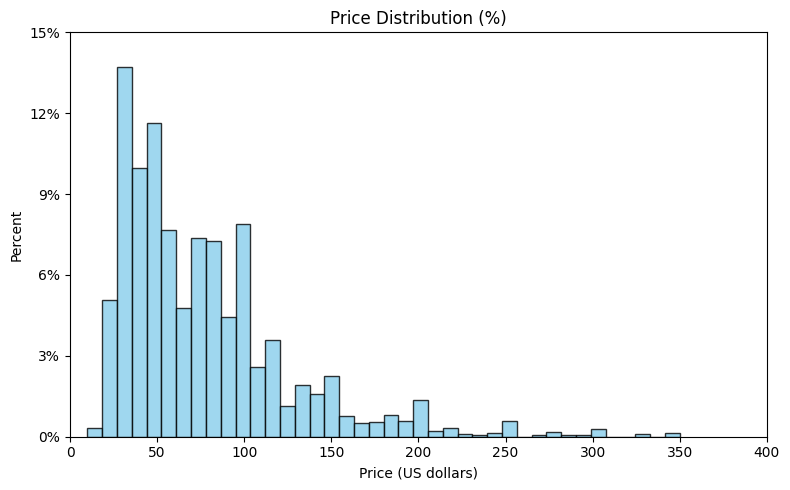

In [22]:
plt.figure(figsize=(8, 5))
plt.hist(datau["price"], bins=40, color="skyblue", edgecolor="black", alpha=0.8, weights=np.ones(len(datau)) / len(datau))
plt.xlabel("Price (US dollars)")
plt.ylabel("Percent")
plt.title("Price Distribution (%)")
plt.xlim(0, 400)
plt.ylim(0, 0.15)
plt.yticks(np.arange(0, 0.16, 0.03), [f"{int(x*100)}%" 
                                      for x in np.arange(0, 0.16, 0.03)])
plt.xticks(np.arange(0, 401, 50))
plt.tight_layout()
plt.show()


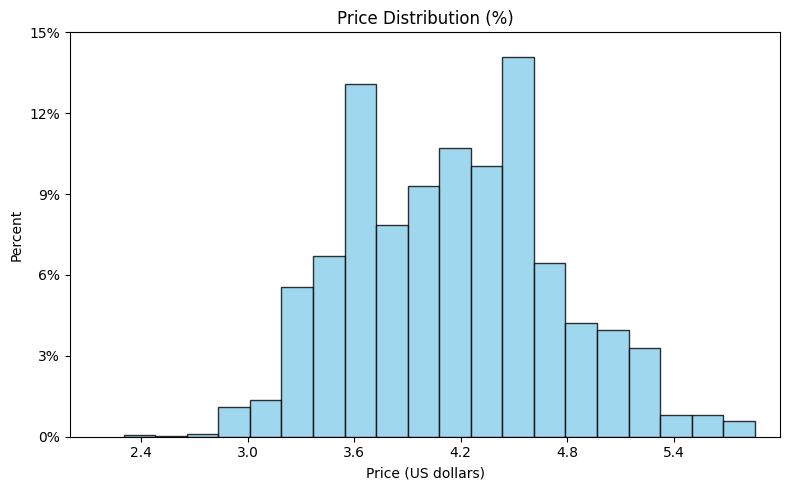

In [23]:
plt.figure(figsize=(8, 5))
plt.hist(datau["ln_price"], bins=20, color="skyblue", edgecolor="black", alpha=0.8, weights=np.ones(len(datau)) / len(datau))
plt.xlabel("Price (US dollars)")
plt.ylabel("Percent")
plt.title("Price Distribution (%)")
plt.xlim(2, 6)
plt.ylim(0, 0.15)
plt.yticks(np.arange(0, 0.16, 0.03), [f"{int(x*100)}%" 
                                      for x in np.arange(0, 0.16, 0.03)])
plt.xticks(np.arange(2.4, 6,0.6))
plt.tight_layout()
plt.show()


### Figure 14.4 Airbnb apartment price distribution by important features

(a) Price by room type

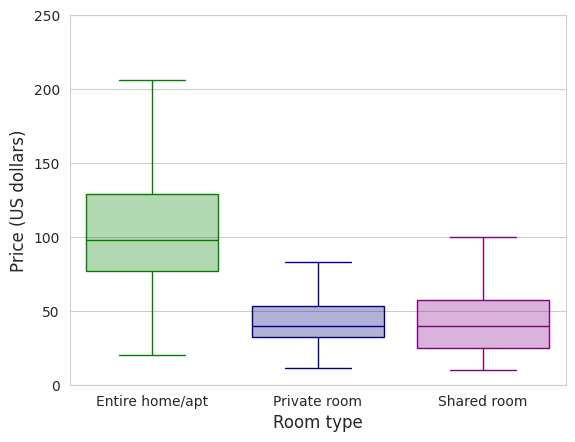

In [24]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
sns.set_style("whitegrid")

datau["f_room_type"] = pd.Categorical(
    datau["f_room_type"], categories=sorted(set(datau["f_room_type"]), reverse=False)
)

fig, ax = plt.subplots()
sns.boxplot(data=datau, x="f_room_type", y="price", width=0.8, ax=ax, showfliers=False)

box_line_col = ["green", "navy", "purple"]
for i, box_col in enumerate(box_line_col):
    mybox = ax.patches[i]
    mybox.set_facecolor(mpl.colors.to_rgba(box_col, 0.3))
    mybox.set_edgecolor(box_col)
    for j in range(i * 5, i * 5 + 5):
        line = ax.lines[j]
        line.set_color(box_col)

plt.ylabel("Price (US dollars)", size=12)
plt.xlabel("Room type", size=12)
plt.yticks(np.arange(0, 300, 50))
plt.show()

(b) Price by number of people accommodated and apartment versus house in US dollars

In [25]:
datau["n_accommodates"] = datau["n_accommodates"].astype(int).astype("category")

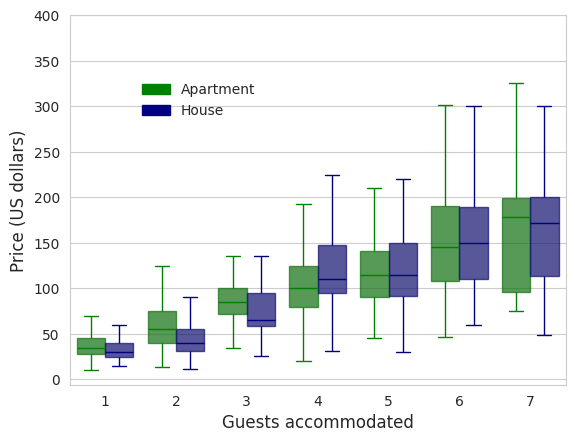

In [26]:
fig, ax = plt.subplots()
# Create the boxplot
sns.boxplot(
    x='n_accommodates',
    y='price',
    hue='f_property_type',
    data=datau,
    showfliers = False,
    palette={'Apartment': "green", 'House': "navy"}
)


for patch in ax.patches:
    r, g, b, _ = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
    patch.set_edgecolor((r, g, b, 0.7))


for i in range(0,int(len(ax.lines)/2)):
    ax.lines[i].set_color("green")

for i in range(int(len(ax.lines)/2),len(ax.lines)):
    ax.lines[i].set_color("navy")

ax.legend(bbox_to_anchor=(0.4, 0.85), framealpha=0)
leg = ax.get_legend()
leg.set_title(None)
leg.legend_handles[0].set_color("green")
leg.legend_handles[1].set_color("navy")

plt.ylabel("Price (US dollars)", size=12)
plt.xlabel("Guests accommodated", size=12)
plt.yticks(np.arange(0, 401, 50))
plt.show()

### Part2

In [27]:
data = pd.read_csv("airbnb_hackney_work.csv")

In [28]:
data.columns

Index(['f_property_type', 'f_room_type', 'f_room_type2',
       'f_cancellation_policy', 'f_bed_type', 'f_neighbourhood_cleansed',
       'usd_price_day', 'n_accommodates', 'n_bathrooms',
       'n_review_scores_rating', 'n_number_of_reviews', 'n_guests_included',
       'n_reviews_per_month', 'n_extra_people', 'n_minimum_nights', 'n_beds',
       'n_days_since', 'd_reviews_per_month', 'd_24-hour check-in',
       'd_air conditioning', 'd_breakfast', 'd_buzzer/wireless intercom',
       'd_cable tv', 'd_carbon monoxide detector', 'd_cat(s)', 'd_dog(s)',
       'd_doorman', 'd_doorman entry', 'd_dryer', 'd_elevator in building',
       'd_essentials', 'd_family/kid friendly', 'd_fire extinguisher',
       'd_first aid kit', 'd_free parking on premises',
       'd_free parking on street', 'd_gym', 'd_hair dryer', 'd_hangers',
       'd_heating', 'd_hot tub', 'd_indoor fireplace', 'd_internet', 'd_iron',
       'd_keypad', 'd_kitchen', 'd_laptop friendly workspace',
       'd_lock on bedr

In [61]:
data["ln_price"] = np.log(data["price"])

In [62]:
data.columns = data.columns.str.replace('/', '')
data.columns = data.columns.str.replace('-', '')
data.columns = data.columns.str.replace(' ', '_')
data.columns = data.columns.str.replace('(s)', '')


data.columns


Index(['f_property_type', 'f_room_type', 'f_room_type2',
       'f_cancellation_policy', 'f_bed_type', 'f_neighbourhood_cleansed',
       'usd_price_day', 'n_accommodates', 'n_bathrooms',
       'n_review_scores_rating', 'n_number_of_reviews', 'n_guests_included',
       'n_reviews_per_month', 'n_extra_people', 'n_minimum_nights', 'n_beds',
       'n_days_since', 'd_reviews_per_month', 'd_24hour_checkin',
       'd_air_conditioning', 'd_breakfast', 'd_buzzerwireless_intercom',
       'd_cable_tv', 'd_carbon_monoxide_detector', 'd_cat', 'd_dog',
       'd_doorman', 'd_doorman_entry', 'd_dryer', 'd_elevator_in_building',
       'd_essentials', 'd_familykid_friendly', 'd_fire_extinguisher',
       'd_first_aid_kit', 'd_free_parking_on_premises',
       'd_free_parking_on_street', 'd_gym', 'd_hair_dryer', 'd_hangers',
       'd_heating', 'd_hot_tub', 'd_indoor_fireplace', 'd_internet', 'd_iron',
       'd_keypad', 'd_kitchen', 'd_laptop_friendly_workspace',
       'd_lock_on_bedroom_door',

In [63]:
data["f_number_of_reviews"] = data["f_number_of_reviews"].astype("category")

### Setting up models

Basic variables

In [64]:
basic_lev = (
    "n_accommodates",
    "n_beds",
    "n_days_since",
    "f_property_type",
    "f_room_type",
    "f_bed_type"
#    "flag_days_since",
)
basic_add = ("f_bathroom", "f_cancellation_policy")
reviews = ("n_review_scores_rating", "f_number_of_reviews", "flag_review_scores_rating")
poly_lev = ("n_accommodates2", "n_days_since2", "n_days_since3")
# not use p_host_response_rate due to missing obs
amenities = tuple(list(data.filter(regex="^d_.*")))


### Look for interactions

Use custom function `price_diff_by_variables` to calculate price differences by given variables

In [65]:
def price_diff_by_variables(df, var1, var2, var1_label, var2_label):
    """
    Calculate mean price for each combination of var1 and var2.
    Returns a DataFrame with the results and appropriate labels.
    """
    # Group by the two variables and calculate mean price
    result = (
        df.groupby([var1, var2])
        .agg(mean_price=('price', 'mean'), count=('price', 'size'))
        .reset_index()
    )
    # Rename columns for clarity
    result = result.rename(
        columns={
            var1: var1_label,
            var2: var2_label,
            'mean_price': 'Mean Price',
            'count': 'Count'
        }
    )
    return result

In [66]:
p1 = price_diff_by_variables(
    data, "f_room_type", "d_familykid_friendly", "Room type", "Family kid friendly"
)
p2 = price_diff_by_variables(
    data, "f_room_type", "f_property_type", "Room type", "Property type"
)
p3 = price_diff_by_variables(
    data,
    "f_cancellation_policy",
    "d_familykid_friendly",
    "Cancellation policy",
    "Family kid friendly",
)
p4 = price_diff_by_variables(
    data, "f_cancellation_policy", "d_tv", "Cancellation policy", "TV"
)
p5 = price_diff_by_variables(data, "f_property_type", "d_cat", "Property type", "Cats")

p6 = price_diff_by_variables(data, "f_property_type", "d_dog", "Property type", "Dogs")

In [67]:
data.columns

Index(['f_property_type', 'f_room_type', 'f_room_type2',
       'f_cancellation_policy', 'f_bed_type', 'f_neighbourhood_cleansed',
       'usd_price_day', 'n_accommodates', 'n_bathrooms',
       'n_review_scores_rating', 'n_number_of_reviews', 'n_guests_included',
       'n_reviews_per_month', 'n_extra_people', 'n_minimum_nights', 'n_beds',
       'n_days_since', 'd_reviews_per_month', 'd_24hour_checkin',
       'd_air_conditioning', 'd_breakfast', 'd_buzzerwireless_intercom',
       'd_cable_tv', 'd_carbon_monoxide_detector', 'd_cat', 'd_dog',
       'd_doorman', 'd_doorman_entry', 'd_dryer', 'd_elevator_in_building',
       'd_essentials', 'd_familykid_friendly', 'd_fire_extinguisher',
       'd_first_aid_kit', 'd_free_parking_on_premises',
       'd_free_parking_on_street', 'd_gym', 'd_hair_dryer', 'd_hangers',
       'd_heating', 'd_hot_tub', 'd_indoor_fireplace', 'd_internet', 'd_iron',
       'd_keypad', 'd_kitchen', 'd_laptop_friendly_workspace',
       'd_lock_on_bedroom_door',

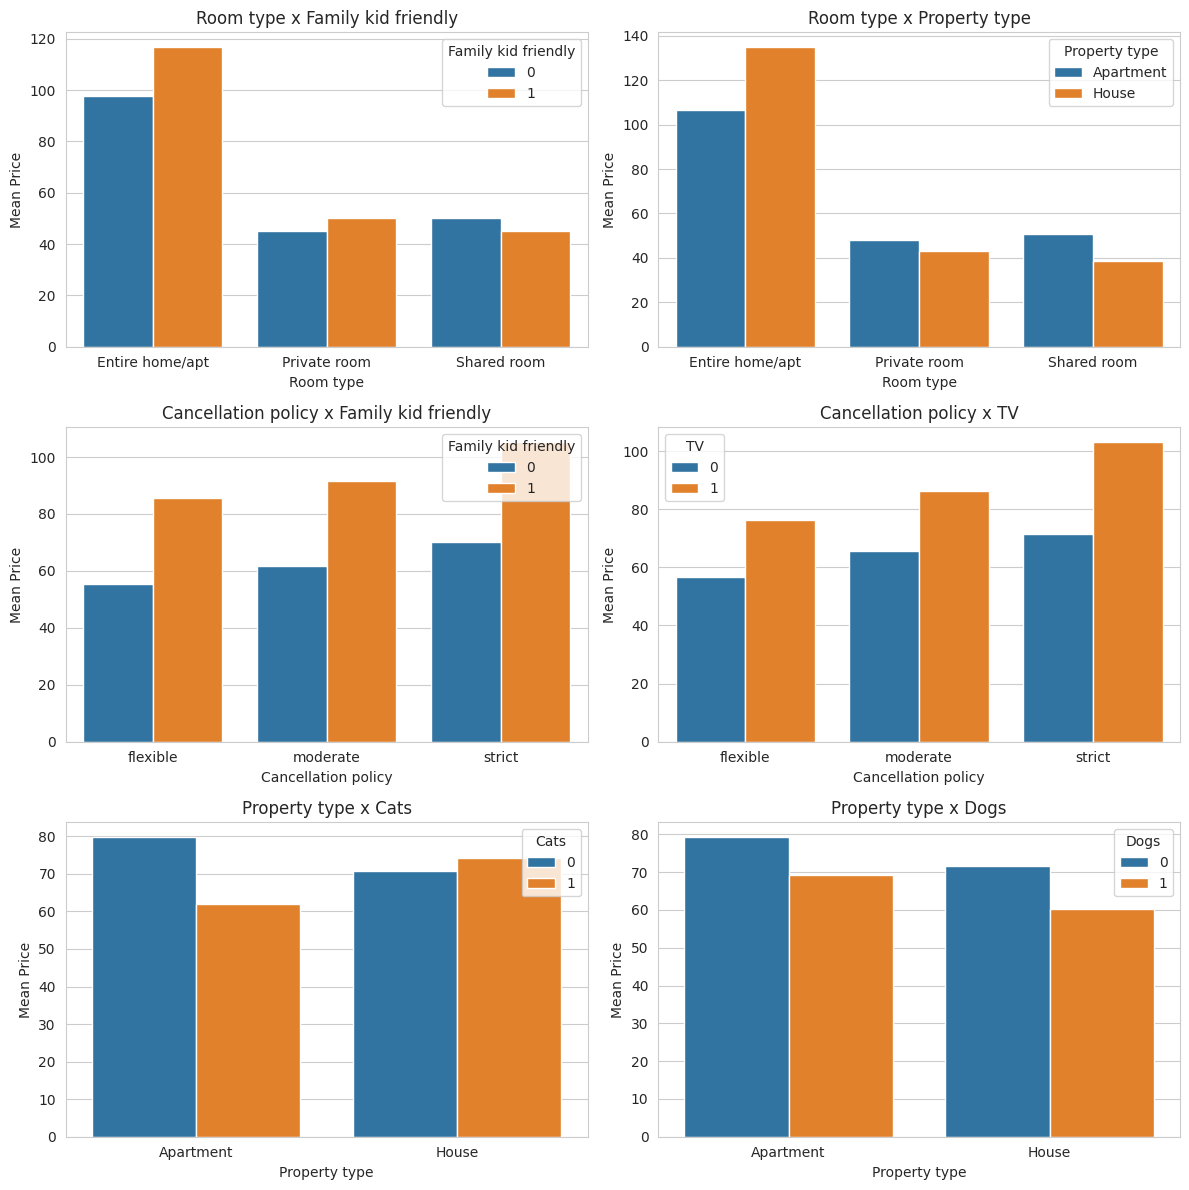

In [58]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Plot 1: Room type vs Family kid friendly
sns.barplot(
    data=p1, x="Room type", y="Mean Price", hue="Family kid friendly", ax=axes[0, 0]
)
axes[0, 0].set_title("Room type x Family kid friendly")

# Plot 2: Room type vs Property type
sns.barplot(
    data=p2, x="Room type", y="Mean Price", hue="Property type", ax=axes[0, 1]
)
axes[0, 1].set_title("Room type x Property type")

# Plot 3: Cancellation policy vs Family kid friendly
sns.barplot(
    data=p3, x="Cancellation policy", y="Mean Price", hue="Family kid friendly", ax=axes[1, 0]
)
axes[1, 0].set_title("Cancellation policy x Family kid friendly")

# Plot 4: Cancellation policy vs TV
sns.barplot(
    data=p4, x="Cancellation policy", y="Mean Price", hue="TV", ax=axes[1, 1]
)
axes[1, 1].set_title("Cancellation policy x TV")

# Plot 5: Property type vs Cats
sns.barplot(
    data=p5, x="Property type", y="Mean Price", hue="Cats", ax=axes[2, 0]
)
axes[2, 0].set_title("Property type x Cats")

# Plot 6: Property type vs Dogs
sns.barplot(
    data=p6, x="Property type", y="Mean Price", hue="Dogs", ax=axes[2, 1]
)
axes[2, 1].set_title("Property type x Dogs")

plt.tight_layout()
plt.show()

Dummies suggested by graphs

In [68]:
data["f_bed_type"].unique()

array(['Real Bed', 'Couch'], dtype=object)

In [69]:
X1 = (
    "f_room_type*f_property_type",
    "f_number_of_reviews*f_property_type",
)

X2 = (
    "d_air_conditioning*f_property_type",
    "d_pets_allowed*f_property_type",
)

X3 = (
    "(f_property_type + f_bed_type) * ("
    + "+".join(amenities)
    + ")"
)

Create estimation equations

In [70]:
modellev1 = "~ n_accommodates"
modellev2 = "~" + " + ".join(basic_lev)
modellev3 = "~" + " + ".join(basic_lev + basic_add + reviews)
modellev4 = "~" + " + ".join(basic_lev + basic_add + reviews + poly_lev)
modellev5 = "~" + " + ".join(basic_lev + basic_add + reviews + poly_lev + X1)
modellev6 = "~" + " + ".join(basic_lev + basic_add + reviews + poly_lev + X1 + X2)
modellev7 = "~" + " + ".join(
    basic_lev + basic_add + reviews + poly_lev + X1 + X2 + amenities
)
modellev8 = (
    "~"
    + "+".join(basic_lev + basic_add + reviews + poly_lev + X1 + X2 + amenities)
    + "+"
    + X3
)

model_equations = [
    modellev1,
    modellev2,
    modellev3,
    modellev4,
    modellev5,
    modellev6,
    modellev7,
    modellev8,
]

### Create separate holdout set

In [42]:
sample_size = round(0.2 * data.shape[0]) - 1

 Set the random number generator: It will make results reproducable

In [71]:
np.random.seed(20180123)

In [44]:
from sklearn.model_selection import train_test_split

data_work, data_holdout = train_test_split(data, test_size=sample_size)

### Crossvalidation

Use custom function `ols_crossvalidator` for cross validation

In [45]:
n_folds = 5

In [72]:
def ols_crossvalidator(equation, data, n_fold=n_folds):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    train_r2_list = []
    bic_list = []
    coef_count_list = []
    train_rmse_list = []
    test_rmse_list = []

    for train_index, test_index in kf.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        model = smf.ols(equation, data=train_data).fit()

        # Predictions
        y_train = train_data[equation.split("~")[0].strip()]
        y_test = test_data[equation.split("~")[0].strip()]
        y_train_pred = model.predict(train_data)
        y_test_pred = model.predict(test_data)

        # Metrics
        train_r2_list.append(model.rsquared)
        bic_list.append(model.bic)
        coef_count_list.append(len(model.params))
        train_rmse_list.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        test_rmse_list.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

    # Average across folds
    return {
        "R-squared": np.mean(train_r2_list),
        "BIC": np.mean(bic_list),
        "Coefficients": int(np.mean(coef_count_list)),
        "Training RMSE": np.mean(train_rmse_list),
        "Test RMSE": np.mean(test_rmse_list)
    }

In [73]:
data_work.columns

Index(['f_property_type', 'f_room_type', 'f_room_type2',
       'f_cancellation_policy', 'f_bed_type', 'f_neighbourhood_cleansed',
       'usd_price_day', 'n_accommodates', 'n_bathrooms',
       'n_review_scores_rating', 'n_number_of_reviews', 'n_guests_included',
       'n_reviews_per_month', 'n_extra_people', 'n_minimum_nights', 'n_beds',
       'n_days_since', 'd_reviews_per_month', 'd_24hour_checkin',
       'd_air_conditioning', 'd_breakfast', 'd_buzzerwireless_intercom',
       'd_cable_tv', 'd_carbon_monoxide_detector', 'd_cat', 'd_dog',
       'd_doorman', 'd_doorman_entry', 'd_dryer', 'd_elevator_in_building',
       'd_essentials', 'd_familykid_friendly', 'd_fire_extinguisher',
       'd_first_aid_kit', 'd_free_parking_on_premises',
       'd_free_parking_on_street', 'd_gym', 'd_hair_dryer', 'd_hangers',
       'd_heating', 'd_hot_tub', 'd_indoor_fireplace', 'd_internet', 'd_iron',
       'd_keypad', 'd_kitchen', 'd_laptop_friendly_workspace',
       'd_lock_on_bedroom_door',

Set number of folds

Cross validate for each model and save results in `cv_list`

In [74]:
cv_list = []
for equation in model_equations:
    result = ols_crossvalidator("ln_price" + equation, data_work, n_fold=n_folds)
    cv_list.append(result)

### Table 14.3 Comparing model fit measures

In [78]:
import statsmodels.formula.api as smf

model3 = smf.ols("ln_price" + modellev3, data=data).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     558.2
Date:                Fri, 01 Aug 2025   Prob (F-statistic):               0.00
Time:                        03:02:55   Log-Likelihood:                -1676.2
No. Observations:                4393   AIC:                             3382.
Df Residuals:                    4378   BIC:                             3478.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [79]:
model = smf.ols(formula="ln_price ~ " + " + ".join(basic_lev), data=data).fit()
print(model.params)
print(len(model.params))  # Should be 16

Intercept                      3.890891
f_property_type[T.House]      -0.056426
f_room_type[T.Private room]   -0.576685
f_room_type[T.Shared room]    -0.623187
f_bed_type[T.Real Bed]         0.150466
n_accommodates                 0.153183
n_beds                        -0.001719
n_days_since                   0.000053
dtype: float64
8


In [80]:
model = smf.ols(formula="ln_price ~ " + " + ".join(basic_lev + basic_add + reviews), data=data).fit()
print(model.params)
print(len(model.params))  # Should be 16

Intercept                            3.374861
f_property_type[T.House]            -0.080046
f_room_type[T.Private room]         -0.594580
f_room_type[T.Shared room]          -0.664800
f_bed_type[T.Real Bed]               0.139152
f_cancellation_policy[T.moderate]   -0.007990
f_cancellation_policy[T.strict]      0.022546
f_number_of_reviews[T.1.0]          -0.154511
f_number_of_reviews[T.2.0]          -0.098247
n_accommodates                       0.147386
n_beds                              -0.009936
n_days_since                         0.000060
f_bathroom                           0.136624
n_review_scores_rating               0.005575
flag_review_scores_rating           -0.042931
dtype: float64
15


In [81]:
compare_model_fits = (
    pd.DataFrame(cv_list)
    .round(2)
    .assign(Model=["M" + str(i + 1) for i in range(len(cv_list))])
    .loc[:, ["Model", "Coefficients", "R-squared", "BIC", "Training RMSE", "Test RMSE"]]
)

compare_model_fits

,Model,Coefficients,R-squared,BIC,Training RMSE,Test RMSE
0,M1,2,0.47,3264.44,0.43,0.43
1,M2,8,0.63,2333.74,0.36,0.36
2,M3,15,0.65,2208.59,0.35,0.35
3,M4,18,0.65,2225.55,0.35,0.35
4,M5,22,0.65,2236.33,0.35,0.35
5,M6,26,0.65,2257.50,0.35,0.35
6,M7,74,0.68,2372.02,0.33,0.34
7,M8,172,0.69,2918.40,0.33,0.37


### Figure 14.7 Training and test set RMSE for the eight regression models

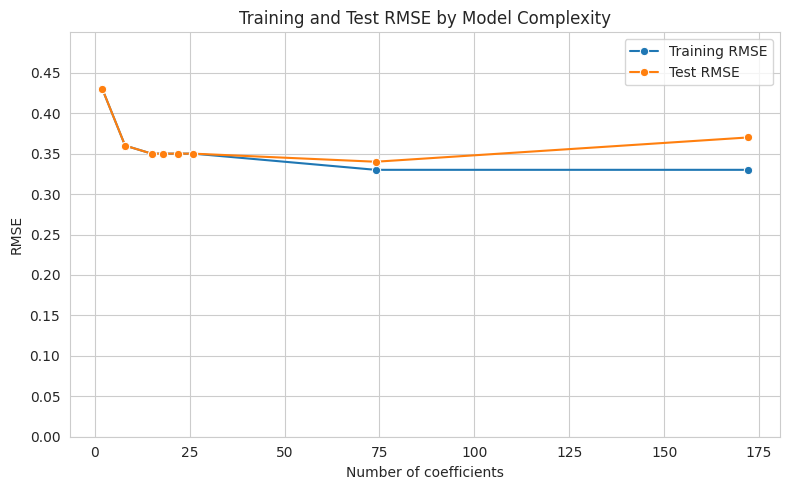

In [84]:
import seaborn as sns

import matplotlib.pyplot as plt

melted = compare_model_fits.melt(
    id_vars="Coefficients", value_vars=["Training RMSE", "Test RMSE"]
)

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=melted,
    x="Coefficients",
    y="value",
    hue="variable",
    marker="o"
)
plt.xlabel("Number of coefficients")
plt.ylabel("RMSE")
plt.ylim(0, 0.5)
plt.yticks(np.arange(0, 0.5, 0.05))
plt.title("Training and Test RMSE by Model Complexity")
plt.legend(title="")
plt.tight_layout()
plt.show()

**NOTE:** Because the way we created the work and holdout sets relies on randomization, these results (eg. the number of coefficients) differ from R and book results. Even running the cross validation with exactly the same work set would result in slightly different RMSE results because we cannot control for the randomisation within the cross validation. Using exactly the same work set as R, the number of coefficients match though.

### Lasso

In [85]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

In [86]:
len(amenities)

50

Define Lasso equation from most complicated model

In [87]:
vars_model_8 = modellev8

Define range for lambdas – the algo will look only in this set

In [88]:
lambdas = np.arange(0.05, 1.01, 0.05)
print(lambdas)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]


To cross-validate lambda-s (which is Lasso's hyperparameter) one has to standardise the feature matrix.

In [89]:
y, X = patsy.dmatrices("ln_price" + vars_model_8, data_work)
X_featnames = X.design_info.column_names
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [90]:
lasso_fit = LassoCV(alphas=lambdas, cv=5, random_state=42).fit(X, y)

Best alpha the algorithm found

In [91]:
lasso_fit.alpha_

np.float64(0.05)

In [92]:
rmse_lambda_folds = (
    pd.DataFrame(lasso_fit.mse_path_, index=lambdas[::-1])
    .apply(np.sqrt)
    .mean(axis=1)
    .to_frame(name="Test RMSE")
    .round(2)
)
rmse_lambda_folds

,Test RMSE
1.00,0.59
0.95,0.59
0.90,0.59
0.85,0.59
0.80,0.59
0.75,0.59
0.70,0.59
0.65,0.59
0.60,0.59
0.55,0.59


Non-zero coefficients

In [93]:
notnull_lasso_coefs = (
    pd.DataFrame(lasso_fit.coef_, index=X_featnames, columns=["coefficient"])
    .loc[lambda x: x["coefficient"].round(3) != 0]
    .round(3)
)
notnull_lasso_coefs

,coefficient
f_room_type[T.Private room],-0.257
f_room_type[T.Shared room],-0.003
f_room_type[T.Private room]:f_property_type[T.House],-0.003
n_accommodates,0.185
f_bathroom,0.011
f_bed_type[T.Real Bed]:d_dryer,0.003
f_bed_type[T.Real Bed]:d_tv,0.018


In [94]:
compare_model_fits.loc[8, :] = {
    "Model": "Lasso",
    "Coefficients": notnull_lasso_coefs.shape[0],
    "Test RMSE": rmse_lambda_folds.loc[lasso_fit.alpha_].round(2).values[0],
}

compare_model_fits

,Model,Coefficients,R-squared,BIC,Training RMSE,Test RMSE
0,M1,2.0,0.47,3264.44,0.43,0.43
1,M2,8.0,0.63,2333.74,0.36,0.36
2,M3,15.0,0.65,2208.59,0.35,0.35
3,M4,18.0,0.65,2225.55,0.35,0.35
4,M5,22.0,0.65,2236.33,0.35,0.35
5,M6,26.0,0.65,2257.50,0.35,0.35
6,M7,74.0,0.68,2372.02,0.33,0.34
7,M8,172.0,0.69,2918.40,0.33,0.37
8,Lasso,7.0,NaN,NaN,NaN,0.37


The overall RMSE across the five test sets for the LASSO regression is 36.3. It is 36.49 for M7,
suggesting that our hand-picked M7 is almost as good as the LASSO regression. Our decision is to have the model M7 as our preferred
model, because it may be easier to explain which variables are included.

### Part3

#### Model diagnostics

In [95]:
model7 = smf.ols("ln_price" + modellev7, data=data_work).fit()

Save the predicted values of model 7 ton data_holdout

In [96]:
data_holdout["predicted_price"] = model7.predict(data_holdout)

Look at holdout RMSE of M7

In [98]:
rmse(data_holdout["predicted_price"], data_holdout["ln_price"])

np.float64(0.35384580723880704)

work set RMSE refitted on the whole work set

In [99]:
rmse(model7.predict(data_work), data_work["ln_price"])

np.float64(0.33383532764636925)

### Fitted vs actual outcome

### Figure 14.8 Airbnb prediction – model diagnostics

(a) Predicted price vs. actual price

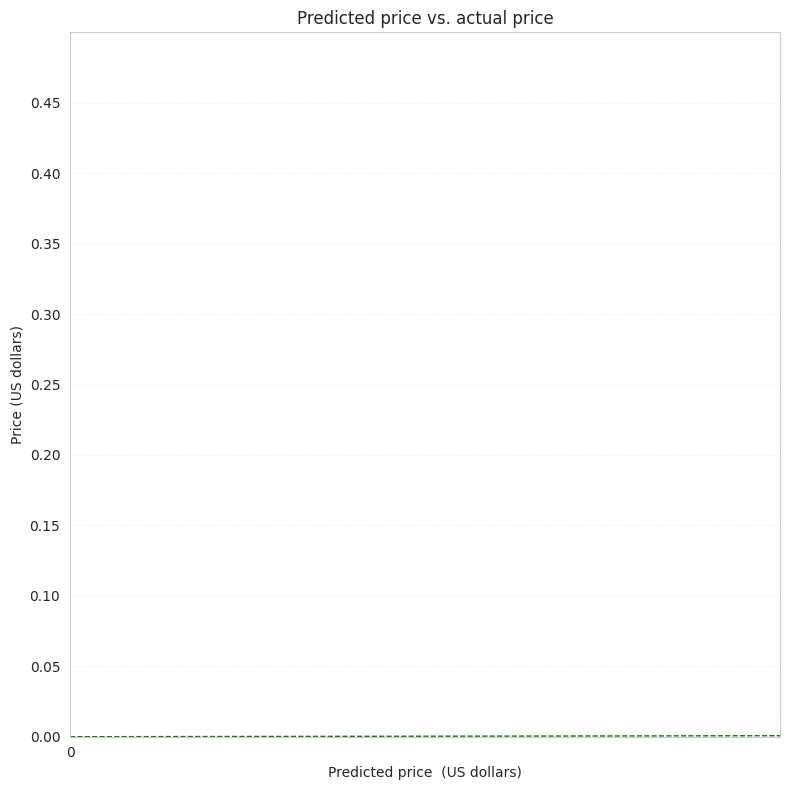

In [103]:
plt.figure(figsize=(8,8))
sns.scatterplot(
    data=data_holdout,
    x="predicted_price",
    y="ln_price",
    color="navy",
    s=10,
    alpha=0.7,
    legend=False
)

# Plot y=x reference line
plt.plot([0, 350], [0, 0.5], linestyle="dashed", color="green", linewidth=1)

plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.xticks(np.arange(0, 0.5, 50))
plt.yticks(np.arange(0, 0.5, 0.05))
plt.xlabel("Predicted price  (US dollars)")
plt.ylabel("Price (US dollars)")
plt.title("Predicted price vs. actual price")
plt.grid(True, linestyle=':', alpha=0.3)
plt.tight_layout()
plt.show()

Redo predicted values at 80% PI


In [ ]:
prediction_agg_by_nacc = (
    model7.get_prediction(data_holdout)
    .summary_frame(alpha=0.2)
    .filter(["mean", "obs_ci_lower", "obs_ci_upper"])
    .rename(columns={"mean": "predicted_price"})
    .assign(n_accommodates=data_holdout["n_accommodates"].values)
    .groupby(by=["n_accommodates"])
    .mean()
    .reset_index()
)

(b) Prediction interval by apartment size

In [ ]:
(
    ggplot(prediction_agg_by_nacc, aes(x="n_accommodates"))
    + geom_bar(aes(y="predicted_price"), stat="identity", fill=color[0], alpha=0.7)
    + geom_errorbar(
        aes(ymin="obs_ci_lower", ymax="obs_ci_upper"), color=color[1], width=0.2
    )
    + scale_y_continuous(name="Predicted price (US dollars)")
    + scale_x_continuous(name="Accomodates (Persons)", breaks=seq(1, 7, 1))
    + scale_color_manual(values=(color[1], color[1]))
    + theme_bw()
    + theme(legend_title=element_blank(), legend_position="none")
)

NameError: name 'prediction_agg_by_nacc' is not defined

Density chart (not in book)

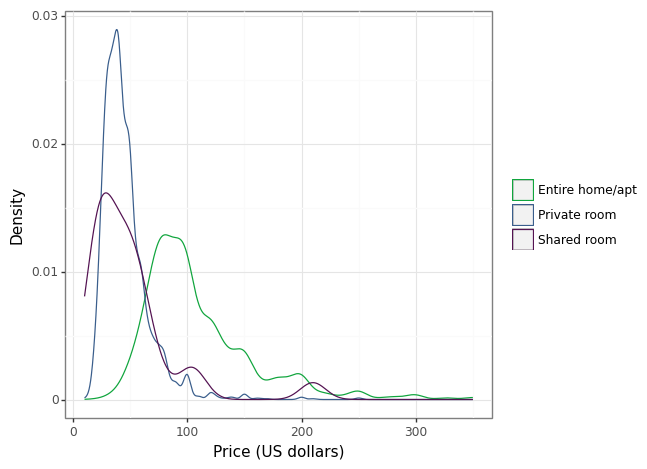

<Figure Size: (640 x 480)>

In [ ]:
(
    ggplot(datau, aes(x="price", color="factor(f_room_type)"))
    + geom_density(na_rm=True, alpha=0.3)
    + scale_color_manual(name="", values=(color[1], color[0], color[2]))
    + labs(x="Price (US dollars)", y="Density", color="")
    + theme_bw()
    + theme(
        legend_position="right",
        legend_title=element_blank(),
        legend_direction="vertical",
        legend_background=element_blank(),
        legend_box_background=element_rect(color="white"),
    )
)

Barchart  (not in book)

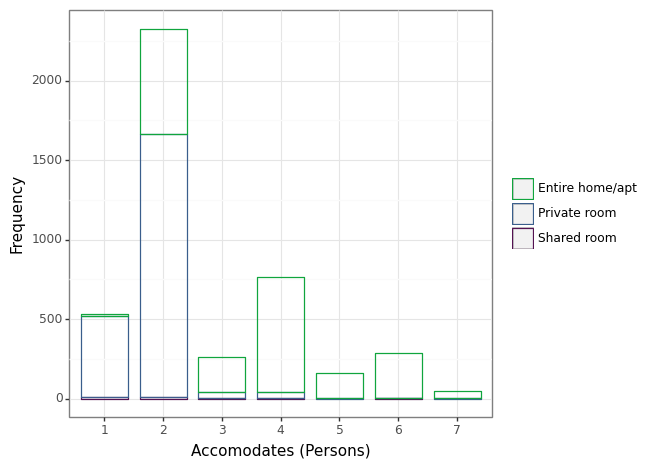

<Figure Size: (640 x 480)>

In [ ]:
(
    ggplot(datau, aes(x="factor(n_accommodates)", color="f_room_type"))
    + geom_bar(alpha=0.8, na_rm=True, width=0.8, fill=None)
    + scale_color_manual(name="", values=(color[1], color[0], color[2]))
    + labs(x="Accomodates (Persons)", y="Frequency")
    + theme_bw()
    + theme(
        legend_position="right",
        legend_title=element_blank(),
        legend_direction="vertical",
        legend_background=element_blank(),
        legend_box_background=element_rect(color="white"),
    )
)